# 1 Process Network data
### Import the tableNetwork
- NaT are replaced with nan (otherwise they are not recognised as nans)

In [1]:
import scipy as sp
print(sp.__version__)

1.2.1


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
#from lifelines import CoxPHFitter
df_tableTest = pd.read_csv(r'DF_BLIND_tableNetwork.csv', index_col=0, sep="|", na_values=['NA'])
df_tableTest['BeginDAS44_datum'] = df_tableTest['BeginDAS44_datum'].replace('NaT', np.nan)


### 1.1 Adjust the network table
Categorize the patients with the following columns (subdivided into three groups):
1. Age at inclusion
2. Year of birth 
3. asses durationCOX (either duration til remission or total duration trajectory) 

In [3]:
def ageGroup(row):
    if row['yearOfBirth'] > 1923 and row['yearOfBirth'] < 1946 :
        row['yob'] = 1
    elif row['yearOfBirth'] > 1945 and row['yearOfBirth'] < 1959 :
        row['yob'] = 2
    elif row['yearOfBirth'] > 1958 and row['yearOfBirth'] < 1993 :
        row['yob'] = 3
    return row

def inclGroup(row):
    if row['incl'] > 20 and row['incl'] < 54:
        row['age'] = 1
    elif row['incl'] > 53 and row['incl'] < 67:
        row['age'] = 2
    elif row['incl'] > 66 and row['incl'] < 90:
        row['age'] = 3
    return row

def firstVisitDate(row):
    if pd.to_datetime(row['Bezdat0'], format="%d-%m-%Y") > pd.to_datetime('2013-10-01') and pd.to_datetime(row['Bezdat0'], format="%d-%m-%Y") < pd.to_datetime('2017-03-01'):
        row['firstVisit'] = 1317
    else:
        row['firstVisit'] = 13
    return row


df_tableTest['yob'] = df_tableTest['smoking']
df_tableTest['age'] = df_tableTest['smoking']
df_tableTest['firstVisit'] = df_tableTest['smoking']
df_tableTest['incl'] = df_tableTest['smoking']
df_tableTest['incl'] = pd.to_datetime(df_tableTest['Bezdat0']).dt.year - df_tableTest['yearOfBirth']

df_tableTest = df_tableTest.apply(lambda x: ageGroup(x), axis = 1)
df_tableTest = df_tableTest.apply(lambda x: inclGroup(x), axis = 1)
df_tableTest = df_tableTest.apply(lambda x: firstVisitDate(x), axis = 1)

df_tableTest['duration'] = (pd.to_datetime(df_tableTest['EindDat'], format="%d-%m-%Y") - pd.to_datetime(df_tableTest['Bezdat0'], format="%d-%m-%Y")).dt.days
df_tableTest['remission'] = (pd.to_datetime(df_tableTest['RemissieDat'], format="%d-%m-%Y") - pd.to_datetime(df_tableTest['Bezdat0'], format="%d-%m-%Y")).dt.days
df_tableTest['status'] = ((df_tableTest['remission'] >= 0) & (~df_tableTest['remission'].isna()))

df_tableTest['durationCOX'] = df_tableTest.apply(
    lambda row: row['duration'] if np.isnan(row['remission']) else row['remission'],
    axis=1
)
df_tableTest.head()


,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX
0,XXX,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,1957.0,483.0,266.0,12,2,2,13,55.0,True,266.0
2,XXX,tocilizumab,12-12-2011,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,1937.0,2197.0,205.0,15,1,3,13,74.0,True,205.0
33,XXX,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,1937.0,2197.0,205.0,12,1,3,13,74.0,True,205.0
64,XXX,leflunomide,27-11-2014,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,1937.0,2197.0,205.0,11,1,3,13,74.0,True,205.0
95,XXX,hydroxychloroquine,19-05-2015,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,1937.0,2197.0,205.0,9,1,3,13,74.0,True,205.0


### 1.2 Write updated table to csv

In [5]:
df_tableTest['BeginDAS44_datum'] = df_tableTest['BeginDAS44_datum'].replace('NaT', np.nan)
df_tableTest.to_csv(r'DF_BLIND_EXTRACOLS.csv', sep='|', index=True)

### 1.3 Import the adjusted tableNetwork

In [6]:
df_tableTest = pd.read_csv(r'DF_BLIND_EXTRACOLS.csv', index_col=0, sep="|", na_values=['NA'])
df_tableTest.head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,yearOfBirth,duration,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX
0,XXX,methotrexaat,13-09-2012,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,1957.0,483.0,266.0,12,2,2,13,55.0,True,266.0
2,XXX,tocilizumab,12-12-2011,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,1937.0,2197.0,205.0,15,1,3,13,74.0,True,205.0
33,XXX,methotrexaat,05-10-2012,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,1937.0,2197.0,205.0,12,1,3,13,74.0,True,205.0
64,XXX,leflunomide,27-11-2014,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,1937.0,2197.0,205.0,11,1,3,13,74.0,True,205.0
95,XXX,hydroxychloroquine,19-05-2015,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,1937.0,2197.0,205.0,9,1,3,13,74.0,True,205.0


# 2. Baseline analysis 

### 2.1 Assess initial respons
A new dataframe is created that keeps track of the initial therapy & the status during that therapy (df_full)
##### Steps:
- Initial: assess drug(s) from initial treatment
- Status is updated: remission dat between BeginDat and EindDat then status = 1 else status = 0

In [10]:
df_tableTest["BeginDat"] = pd.to_datetime(df_tableTest["BeginDat"] , format="%d-%m-%Y")
l_firstDat = df_tableTest.sort_values(by="BeginDat").groupby('PATNR').first()['BeginDat']
def assesInitial(row):
    row['initial'] = 0
    if row['BeginDat'] == l_firstDat[row['PATNR']]:
        row['initial'] = 1
    else :
        row['initial'] = 0
    return row

def updateStatusWithinInitial(row):
    row['status'] = 0
    if pd.to_datetime(row['RemissieDat'], format="%d-%m-%Y") >= pd.to_datetime(row['BeginDat'], format="%d-%m-%Y") \
    and pd.to_datetime(row['RemissieDat'], format="%d-%m-%Y") <= pd.to_datetime(row['EindDat'], format="%d-%m-%Y") +pd.Timedelta(pd.offsets.Day(1)):
        row['status'] = 1
    else :
        row['status'] = 0
    return row

df_full = df_tableTest.copy()
df_full['initial'] = df_full['ID']
df_full['TTC'] = (pd.to_datetime(df_full['EindDat'], format="%d-%m-%Y") - pd.to_datetime(df_full['BeginDat'], format="%d-%m-%Y")).dt.days
df_full['EindDat'] = df_full['EindDat'].replace('NaT', np.nan)
df_full['BeginDat'] = df_full['BeginDat'].replace('NaT', np.nan)
df_full = df_full[~(df_full['EindDat'].isna())]
df_full = df_full[~(df_full['BeginDat'].isna())]
df_full = df_full.apply(lambda x: assesInitial(x), axis = 1)
df_full_noStat = df_full.copy()
df_full = df_full.apply(lambda x: updateStatusWithinInitial(x), axis = 1)

print('Patients response to initial therapy:\n')
print('Remission:\t' + str(len(df_full[((df_full['status']==1) & (df_full['initial']==1))])))
print('No Remission:\t' + str(len(df_full[((df_full['status']==0) & (df_full['initial']==1))])))
df_full.head()

Patients response to initial therapy:

Remission:	229
No Remission:	138


,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,remission,drugCode,yob,age,firstVisit,incl,status,durationCOX,initial,TTC
0,XXX,methotrexaat,2012-09-13,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,266.0,12,2,2,13,55.0,1,266.0,1,483.0
2,XXX,tocilizumab,2011-12-12,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,205.0,15,1,3,13,74.0,1,205.0,1,2163.0
33,XXX,methotrexaat,2012-10-05,13-11-2017,1.4,05-10-2012,08-11-2011,methotrexaat822,1.0,31-05-2012,...,205.0,12,1,3,13,74.0,0,205.0,0,1865.0
64,XXX,leflunomide,2014-11-27,13-11-2017,3.5,27-11-2014,08-11-2011,leflunomide2849,1.0,31-05-2012,...,205.0,11,1,3,13,74.0,0,205.0,0,1082.0
95,XXX,hydroxychloroquine,2015-05-19,13-11-2017,2.1,19-05-2015,08-11-2011,hydroxychloroquine9681,1.0,31-05-2012,...,205.0,9,1,3,13,74.0,0,205.0,0,909.0


### 2.2 Create baseline table stats for ACPA

In [11]:
def baselineChar(feat, df_Init):
    drugs = ['methotrexaat', 'hydroxychloroquine']
    characteristics = ['sex', 'RFC', 'status' , 'smoking', 'aCCP'] 
    if feat in characteristics:
        characteristics.remove(feat)
    for feat_present in range(0,2):
        df = df_Init[((df_Init[feat]==feat_present))]
        print('N ' + str(feat) + ':' + str(feat_present) + ' = ' + str(len(df)))
        print('DAS44 (start): ' + str(df['BeginDAS44'].median()) + ' (' + str(df['BeginDAS44'].min()) + '-' + str(df['BeginDAS44'].max()) + ') ')
        print('DAS44 N: ' + str(len([x for x in list(df['BeginDAS44']) if x == x])))
        print('Age at Inclusion: ' + str(df['incl'].median()) + ' (' + str(df['incl'].min()) + '-' + str(df['incl'].max()) + ') ')
        
        print('MTTC: ' + str(df['TTC'].median()) + ' (' + str(df['TTC'].min()) + '-' + str(df['TTC'].max()) + ') ')
        print('MTTC N: ' + str(len([x for x in list(df['TTC']) if x == x])))
        print('TTR : ' + str(df[df['status']==1]['remission'].median()) + ' (' + str(df[df['status']==1]['remission'].min()) + '-' + str(df[df['status']==1]['remission'].max()) + ') ')
        print('TTR N: ' + str(len(list(df[df['status']==1]['remission']))))
        for char in characteristics:
            if char == 'smoking': 
                print('prop. smoking = 0: ' + str(len(df[df[char]==1])) + ' 1: ' + 
                      str(len(df[df[char].isin(list(range(2,8)))])) + '\t\tperc. 1: ' + 
                     str(len(df[df[char].isin(list(range(2,8)))])/len(df[(df[char].isin(list(range(1,8))))])))
            else: 
                try :
                    print('prop. ' + char + ' = 0:' + str(dict(df[char].value_counts())[0]) + 
                          ' 1:'+ str(dict(df[char].value_counts())[1]) + '\t\tperc. 1: ' + 
                            str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())])))
                    #print()
                except: 
                    print('prop. ' + char + ' = ' + str(dict(df[char].value_counts()))+ '\t\tperc. 1: ' + 
                            str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())])))
            #l_size1 = list(df[char].value_counts().values)


        print()
        
idx = df_full_noStat.groupby(['PATNR'])['BeginDat'].transform(min) == df_full['BeginDat'] # BeginDASdatum voor beginDAS
df_proc = df_full_noStat[idx]
df_proc = df_proc.drop_duplicates('PATNR')
        
baselineChar('aCCP', df_proc)

N aCCP:0 = 128
DAS44 (start): 3.1 (1.1-6.3) 
DAS44 N: 51
Age at Inclusion: 65.0 (21.0-88.0) 
MTTC: 720.0 (13.0-2058.0) 
MTTC N: 128
TTR : 266.0 (14.0-1666.0) 
TTR N: 89
prop. sex = 0:46 1:82		perc. 1: 0.640625
prop. RFC = 0:58 1:15		perc. 1: 0.2054794520547945
prop. status = 0:39 1:89		perc. 1: 0.6953125
prop. smoking = 0: 14 1: 11		perc. 1: 0.44

N aCCP:1 = 190
DAS44 (start): 2.9 (0.2-5.1) 
DAS44 N: 88
Age at Inclusion: 59.0 (21.0-89.0) 
MTTC: 952.0 (14.0-2297.0) 
MTTC N: 190
TTR : 378.5 (0.0-2024.0) 
TTR N: 144
prop. sex = 0:58 1:132		perc. 1: 0.6947368421052632
prop. RFC = 0:8 1:110		perc. 1: 0.9322033898305084
prop. status = 0:46 1:144		perc. 1: 0.7578947368421053
prop. smoking = 0: 16 1: 32		perc. 1: 0.6666666666666666



### 2.3 Create baseline characteristics of total group (where sex is annotated)

In [12]:
from scipy.stats import mannwhitneyu, ttest_ind
characteristics = ['sex', 'RFC', 'status' , 'smoking', 'aCCP'] 
feat = 'sex'
df = df_proc[df_proc[feat].isin([1,0])]

#feat_present = 0
print('N total :' + str(feat) + ' = ' + str(len(df)))
print('DAS44 (start): ' + str(df['BeginDAS44'].median()) + ' (' + str(df['BeginDAS44'].min()) + '-' + str(df['BeginDAS44'].max()) + ') ')
print('DAS44 N: ' + str(len([x for x in list(df['BeginDAS44']) if x == x])))
print('Age at Inclusion: ' + str(df['incl'].median()) + ' (' + str(df['incl'].min()) + '-' + str(df['incl'].max()) + ') ')

print('MTTC: ' + str(df['TTC'].median()) + ' (' + str(df['TTC'].min()) + '-' + str(df['TTC'].max()) + ') ')
print('MTTC N: ' + str(len([x for x in list(df['TTC']) if x == x])))
print('TTR : ' + str(df[df['status']==1]['remission'].median()) + ' (' + str(df[df['status']==1]['remission'].min()) + '-' + str(df[df['status']==1]['remission'].max()) + ') ')
print('TTR N: ' + str(len(list(df[df['status']==1]['remission']))))
for char in characteristics:
    if char == 'smoking': 
        print('prop. smoking = 0: ' + str(len(df[df[char]==1])) + ' 1: ' + 
              str(len(df[df[char].isin(list(range(2,8)))])) + '\t\tperc. 1: ' + 
             str(len(df[df[char].isin(list(range(2,8)))])/len(df[(df[char].isin(list(range(1,8))))])))
    else: 
        try :
            print('prop. ' + char + ' = 0:' + str(dict(df[char].value_counts())[0]) + 
                  ' 1:'+ str(dict(df[char].value_counts())[1]) + '\t\tperc. 1: ' + 
                    str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())])))
            #print()
        except: 
            print('prop. ' + char + ' = ' + str(dict(df[char].value_counts()))+ '\t\tperc. 1: ' + 
                    str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())])))
    #l_size1 = list(df[char].value_counts().values)

subset_var = 'aCCP'
feature = 'BeginDAS44' 
print('\nMannWhitney - DAS between groups (' + subset_var + '): ') 
stat, p = mannwhitneyu(df[((df[subset_var]==0) & (df['status']==1))][feature],df[((df[subset_var]==1) & (df['status']==1))][feature])
print(p)


N total :sex = 346
DAS44 (start): 2.9 (0.2-6.3) 
DAS44 N: 143
Age at Inclusion: 61.0 (21.0-89.0) 
MTTC: 878.0 (0.0-2297.0) 
MTTC N: 346
TTR : 286.5 (0.0-2024.0) 
TTR N: 250
prop. sex = 0:116 1:230		perc. 1: 0.6647398843930635
prop. RFC = 0:71 1:127		perc. 1: 0.6414141414141414
prop. status = 0:96 1:250		perc. 1: 0.7225433526011561
prop. smoking = 0: 35 1: 48		perc. 1: 0.5783132530120482
prop. aCCP = 0:128 1:190		perc. 1: 0.5974842767295597

MannWhitney - DAS between groups (aCCP): 
0.0855916955912625


### 2.4 Create histogram - time to change drug in days

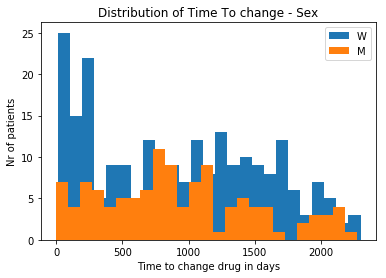

In [15]:
import matplotlib.pyplot as plt

subset_var = 'sex'
feature = 'TTC' 

plt.figure(figsize=(6,4))

#feature = 'remission'
plt.hist(df[df[subset_var]==1][feature], label='W', bins=25)
plt.hist(df[df[subset_var]==0][feature], label='M', bins=25)
plt.title('Distribution of Time To change - Sex')
plt.legend(loc='upper right')
plt.xlabel('Time to change drug in days')
plt.ylabel('Nr of patients')
plt.show()

# 3.Initial treatment Repsons Analysis

### 3.1 Create Initial response subselection
##### Steps:
- Only the initial rows are selected
- All of the drugs from the initial therapy are collected and appended as values
- The longitudinal aspect of the data therefore disappears and a new dataframe is created: df_Init().

In [18]:
import numpy as np

df_full = df_full[(df_full['initial']==1)]


df_full['drug1'] = df_full['smoking']
df_full['drug2'] = df_full['smoking']
df_full['drug3'] = df_full['smoking']
df_full['drug4'] = df_full['smoking']

df_Init = pd.DataFrame(columns=list(df_full.columns))
for pat in df_full['PATNR'].unique():
    df_pat = df_full[df_full['PATNR']==pat]
    l_drugs = list(df_pat['drug'].values)
    d_items = dict(df_pat.iloc[0][:-4])
    d_items.update({'drug1': np.nan, 'drug2': np.nan, 'drug3': np.nan, 'drug4': np.nan})
    for x in range(len(l_drugs)):
        column = 'drug' + str(x+1)
        d_items[column] = l_drugs[x]
    d_items['comed'] = 0 + 1 * (len(l_drugs)>1)
    df_Init = df_Init.append(d_items, ignore_index= True) 
df_Init.head()

,PATNR,drug,BeginDat,EindDat,BeginDAS44,BeginDAS44_datum,Bezdat0,ID,RFC,RemissieDat,...,incl,status,durationCOX,initial,TTC,drug1,drug2,drug3,drug4,comed
0,7800.0,methotrexaat,2012-09-13,09-01-2014,NaN,NaN,13-09-2012,methotrexaat718,0.0,06-06-2013,...,55.0,1,266.0,1,483.0,methotrexaat,NaN,NaN,NaN,0.0
1,102309.0,tocilizumab,2011-12-12,13-11-2017,3.3,12-12-2011,08-11-2011,tocilizumab382,1.0,31-05-2012,...,74.0,1,205.0,1,2163.0,tocilizumab,NaN,NaN,NaN,0.0
2,614879.0,methotrexaat,2012-08-17,22-12-2017,NaN,NaN,12-07-2012,methotrexaat7505,1.0,20-08-2013,...,40.0,1,404.0,1,1953.0,methotrexaat,NaN,NaN,NaN,0.0
3,334769.0,methotrexaat,2012-01-20,15-05-2013,NaN,NaN,28-11-2011,methotrexaat5665,1.0,19-11-2012,...,40.0,1,357.0,1,481.0,methotrexaat,NaN,NaN,NaN,0.0
4,492022.0,methotrexaat,2012-01-24,16-04-2014,NaN,NaN,05-12-2011,methotrexaat6610,1.0,10-04-2012,...,69.0,1,127.0,1,813.0,methotrexaat,NaN,NaN,NaN,0.0


### 3.1 Process initial dataframe
##### Steps:
- Remove the few cases with co-medication as initial therapy 
- Drop columns that are not relevant for the statistical data or that can simply not be used
- Assess the time to change (TTC) -> time till a treatment strategy is changed
- Assess the new duration within the initial treatment (either time till remission or time til change)
- The dataframe is then also written to a csv file


In [10]:

df_Init = df_Init[(df_Init['comed']==0)]
df_Init['status'] = df_Init['status'].astype(float)
df_Init.drug1 = pd.Categorical(df_Init.drug1)
#df_Init = df_Init.drop(['PATNR', 'duration', 'durationCOX', 'RemissieDat', 'Bezdat0', 'BeginDAS44_datum', 'drug2', 'drug3', 'drug4', 'drug', 'ID'], axis=1)
df_Init['TTC'] = (pd.to_datetime(df_Init['EindDat'], format="%d-%m-%Y") - pd.to_datetime(df_Init['BeginDat'], format="%d-%m-%Y")).dt.days
df_Init['durationCOX'] = df_Init.apply(
    lambda row: row['TTC'] if np.isnan(row['remission']) else row['remission'],
    axis=1
)
#df_Init = df_Init.drop(['remission'], axis=1)
df_Init['drug1'].value_counts()

methotrexaat          254
sulfasalazine          27
hydroxychloroquine     22
leflunomide             6
etanercept              5
adalimumab              5
tocilizumab             3
azathioprine            3
certolizumab            2
rituximab               1
infliximab              1
Name: drug1, dtype: int64

### 3.1.1 Histogram for Time to achieve remission 

Text(0, 0.5, 'Nr of patients')

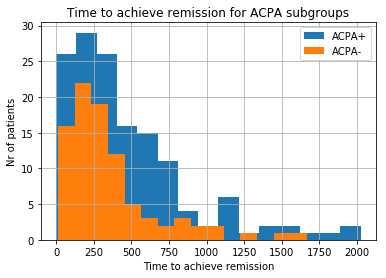

In [19]:
import matplotlib.pyplot as plt

df_Init[((df_Init['aCCP']==1))]['remission'].hist(bins=15)
df_Init[((df_Init['aCCP']==0))]['remission'].hist(bins=15)# .show()
plt.title('Time to achieve remission for ACPA subgroups')
plt.legend(['ACPA+', 'ACPA-'], loc='upper right')
plt.xlabel('Time to achieve remission')
plt.ylabel('Nr of patients')

### 3.2 Get baseline characteristics for different initial treatment options 

In [12]:

def baselineCharTreatment(feat, df_Init):
    drugs = ['methotrexaat', 'hydroxychloroquine', 'sulfasalazine']
    characteristics = ['sex', 'RFC', 'status' , 'smoking'] 
    for feat_present in range(0,2):
        print(feat, feat_present)
        for d in drugs:
            #print(d)
            df = df_Init[((df_Init[feat]==feat_present) & (df_Init['drug1']==d))]
            print('N ' + str(d) + ' = ' + str(len(df)))
            print('DAS44 (start): ' + str(df['BeginDAS44'].median()) + ' (' + str(df['BeginDAS44'].min()) + '-' + str(df['BeginDAS44'].max()) + ') ')
            print('DAS44 N: ' + str(len([x for x in list(df['BeginDAS44']) if x == x])) )
            print('Age at Inclusion: ' + str(df['incl'].median()) + ' (' + str(df['incl'].min()) + '-' + str(df['incl'].max()) + ') ')
            print('MTTC: ' + str(df['TTC'].median()) + ' (' + str(df['TTC'].min()) + '-' + str(df['TTC'].max()) + ') ')
            print('MTTC N: ' + str(len([x for x in list(df['TTC']) if x == x])))
            print('TTR : ' + str(df[df['status']==1]['remission'].median()) + ' (' + str(df[df['status']==1]['remission'].min()) + '-' + str(df[df['status']==1]['remission'].max()) + ') ')
            print('TTR N: ' + str(len(list(df[df['status']==1]['remission']))))
            for char in characteristics:
                if char == 'smoking': 
                    print('prop. smoking = 0: ' + str(len(df[df[char]==1])) + ' 1: ' + 
                          str(len(df[df[char].isin(list(range(2,8)))])) + '\t\tperc. 1: ' + 
                         str(len(df[df[char].isin(list(range(2,8)))])/len(df[(df[char].isin(list(range(1,8))))])) + '\tn:' +
                         str(len(df[(df[char].isin(list(range(1,8))))])))
                else: 
                    try :
                        print('prop. ' + char + ' = 0:' + str(dict(df[char].value_counts())[0]) + 
                              ' 1:'+ str(dict(df[char].value_counts())[1]) + '\t\tperc. 1: ' + 
                                str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())]))+
                                '\tn:' + str(len(df[(~df[char].isna())])))
                        #print()
                    except: 
                        if 1 in list(df[char].value_counts().keys()):
                            print('prop. ' + char + ' = ' + str(dict(df[char].value_counts()))+ '\t\tperc. 1: ' + 
                                    str(dict(df[char].value_counts())[1]/len(df[(~df[char].isna())])) + 
                                    '\tn:' + str(len(df[(~df[char].isna())])))
                        else :
                            print('prop. ' + char + ' = ' + str(dict(df[char].value_counts()))+ '\t\tperc. 0: ' + 
                                    str(dict(df[char].value_counts())[0]/len(df[(~df[char].isna())])) + 
                                    '\tn:' + str(len(df[(~df[char].isna())]))) 
                #l_size1 = list(df[char].value_counts().values)
                
                
            print()
baselineCharTreatment('aCCP', df_Init)


aCCP 0
N methotrexaat = 96
DAS44 (start): 3.3 (1.1-6.3) 
DAS44 N: 43
Age at Inclusion: 65.0 (23.0-86.0) 
MTTC: 736.5 (21-2058) 
MTTC N: 96
TTR : 266.0 (21.0-1666.0) 
TTR N: 60
prop. sex = 0:34 1:62		perc. 1: 0.6458333333333334	n:96
prop. RFC = 0:43 1:12		perc. 1: 0.21818181818181817	n:55
prop. status = 0:36 1:60		perc. 1: 0.625	n:96
prop. smoking = 0: 12 1: 6		perc. 1: 0.3333333333333333	n:18

N hydroxychloroquine = 13
DAS44 (start): 2.8 (2.5-3.8) 
DAS44 N: 4
Age at Inclusion: 73.0 (48.0-88.0) 
MTTC: 543.0 (13-1790) 
MTTC N: 13
TTR : 148.0 (14.0-321.0) 
TTR N: 8
prop. sex = 0:3 1:10		perc. 1: 0.7692307692307693	n:13
prop. RFC = 0:6 1:2		perc. 1: 0.25	n:8
prop. status = 0:5 1:8		perc. 1: 0.6153846153846154	n:13
prop. smoking = 0: 1 1: 1		perc. 1: 0.5	n:2

N sulfasalazine = 6
DAS44 (start): 2.5 (2.5-2.5) 
DAS44 N: 1
Age at Inclusion: 67.5 (21.0-73.0) 
MTTC: 308.5 (18-1663) 
MTTC N: 6
TTR : 215.0 (83.0-1043.0) 
TTR N: 5
prop. sex = 0:1 1:5		perc. 1: 0.8333333333333334	n:6
prop. RFC = {0.0

### 3.3 Fisher exact test - Within ACPA+ differences between HCQ & MTX

In [26]:

feat = 'aCCP'
feat_present = 1
drug = ['hydroxychloroquine','methotrexaat', 'sulfasalazine'][1]
drug2 = ['hydroxychloroquine','methotrexaat', 'sulfasalazine'][1]
test = 'f'
l_size1 = list(df_Init[((df_Init[feat]==1) & (df_Init['drug1']==drug))]['status'].value_counts().sort_index().values)
l_label1 = list(df_Init[((df_Init[feat]==1) & (df_Init['drug1']==drug))]['status'].value_counts().sort_index().keys())
l_size2 = list(df_Init[((df_Init[feat]==0) & (df_Init['drug1']==drug2))]['status'].value_counts().sort_index().values)
l_label2 = list(df_Init[((df_Init[feat]==0) & (df_Init['drug1']==drug2))]['status'].value_counts().sort_index().keys())

obs = np.array([l_size1, l_size2])
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)#u

print('\tInitial Response ACPA+: ')
print(drug + ' :\t\t', l_size1,'\t', l_label1)
print(drug2 + ' :\t', l_size2,'\t', l_label2) 
print()
print('Fisher exact (p):', p)

	Initial Response ACPA+: 
methotrexaat :		 [41, 101] 	 [0.0, 1.0]
methotrexaat :	 [36, 60] 	 [0.0, 1.0]

Fisher exact (p): 0.20358967235504666


## 4. Create Barchart to visualize performance Feature- and Longitudinal evaluation

[0.926]


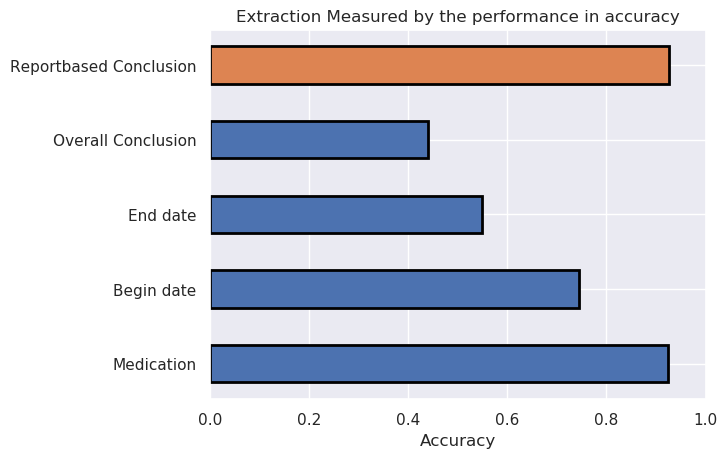

In [77]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

objects = ('Medication', 'Begin date', 'End date', 'Overall Conclusion', 'Reportbased Conclusion')
y_pos = np.arange(len(objects))
performance = [0.924, 0.744, 0.550, 0.44, 0.926]
x = 4
print(performance[x:])
plt.barh(y_pos[:x], performance[:x], 0.5, align='center', alpha=1, linewidth=2, edgecolor='black')
plt.barh(y_pos[x:], performance[x:], 0.5, align='center', alpha=1, linewidth=2, edgecolor='black')

plt.yticks(y_pos, objects)
plt.xlabel('Accuracy')
plt.xlim([0,1])
plt.title('Extraction Measured by the performance in accuracy')

plt.show()

### 4.1 Create a proportion table of initial therapy

0.03227709649024701


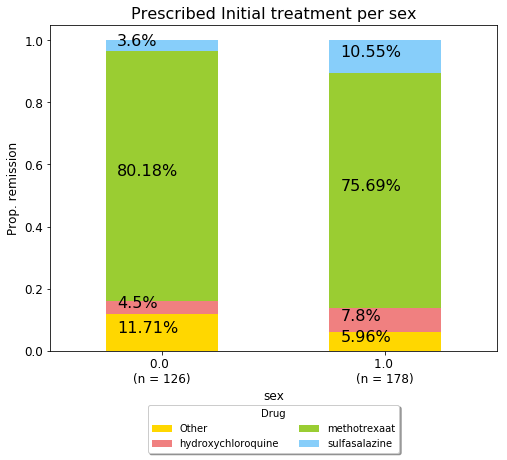

<Figure size 720x288 with 0 Axes>

In [36]:
feat = 'sex'
table=pd.crosstab(df_Init[feat], df_Init['drug1'])

colors = []
for drug in table.keys().tolist():
    colors.append(d_color[drug])

ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(8,6), fontsize= 12, color=colors)
totals = {}

labels = [item.get_text() for item in ax.get_xticklabels()]
count = 0
for x in labels:
    labels[count] = str(x) + ' \n(n = ' + \
        str(len(df_Init[((df_Init['aCCP']==float(x)))])) + ')' 
    count += 1

for i in ax.patches:
    if i.get_height() > 0.02:
        ax.text(i.get_x()+i.get_width()/10, i.get_y()+i.get_height()/2, \
                str(round(i.get_height()*100, 2))+'%', fontsize=16,
                    color='black' ) # bbox=dict(facecolor='green', edgecolor='red')
ax.set_xticklabels(labels, rotation=0)
ax.legend(title='Drug', fontsize= 10, loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
ax.set_title('Prescribed Initial treatment per ' + feat, fontsize= 16)
ax.set_xlabel(feat, fontsize= 12)
ax.set_ylabel('Prop. remission', fontsize= 12)
plt.figure(figsize=(10,4))

obs = np.array(table)
test = 'c'
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)
print(p)

In [160]:
#print(df_Init['drug1'])
df_Init.drug1 = pd.Categorical(df_Init.drug1)
l_drugs = list(df_Init.drug1.cat.categories)
df_Init['drugCode'] = df_Init.drug1.cat.codes 

In [315]:
print(len(df_Init[((df_Init['drug1']=='hydroxychloroquine') & (df_Init['sex']==0.0))]))
print(len(df_Init[(df_Init['sex']==0.0)])-5)
print(len(df_Init[((df_Init['drug1']=='hydroxychloroquine') & (df_Init['sex']==1.0))]))
print(len(df_Init[((df_Init['sex']==1.0))])-17)

5
106
17
201


### Classify rare drugs as Other

In [13]:
feat = 'drug1'
threshold = 10        
#include = [k for k,v in dict(df_Init[feat].value_counts()).items() if v >= threshold]
others = [k for k,v in dict(df_Init[feat].value_counts()).items() if v < threshold]
df_Init[feat] = df_Init[feat].replace(others, 'Other')

### Create dictionary with color per medication

In [14]:
from acronyms import MEDICINE
d_color = {'Other': 'gold'}
count = 0
palette = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'blue', 'yellow', 'green', 'silver', 'pink', 'sienna', 'aqua', 'cyan', 'magenta', 'navy', 'maroon', 'teal', 'orange', 'brown']# viridis(18)
for drug in MEDICINE:
    if drug not in ['prednison', 'prednisolon', 'depomedrol']: 
        d_color[drug] = palette[count]
        count+=1


### 4.3 Create stacked barchart for visualizing initial response 

status  0.0  1.0
aCCP            
0.0      36   60
1.0      41  101
[[36, 60], [41, 101]]
Diff in MTX response by aCCP : 0.2035896723550466
status  0.0  1.0
aCCP            
0.0       5    8
1.0       4    3
[[5, 8], [4, 3]]
Diff in HCQ response by aCCP : 0.6424148606811145
status  0.0  1.0
aCCP            
0.0       1    5
1.0       8    9
[[1, 5], [8, 9]]
Diff in SSZ response by aCCP : 0.340128978572915
sum 178
['methotrexaat', 'sulfasalazine', 'Other', 'hydroxychloroquine']
methotrexaat          142
sulfasalazine          17
Other                  12
hydroxychloroquine      7
Name: drug1, dtype: int64
178
126
sum 126
['methotrexaat', 'hydroxychloroquine', 'Other', 'sulfasalazine']
methotrexaat          96
hydroxychloroquine    13
Other                 11
sulfasalazine          6
Name: drug1, dtype: int64


NameError: name 'obs' is not defined

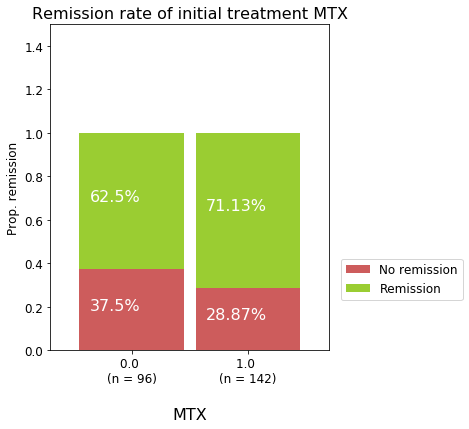

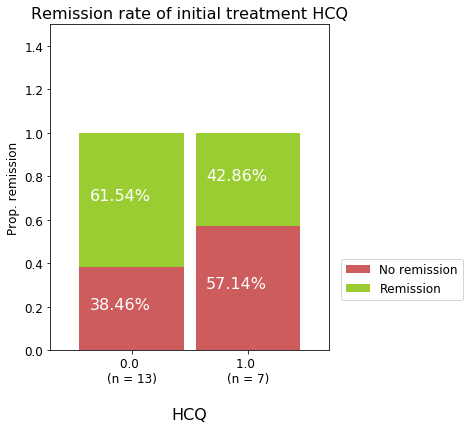

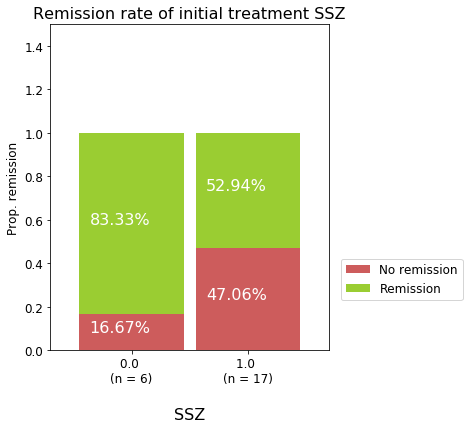

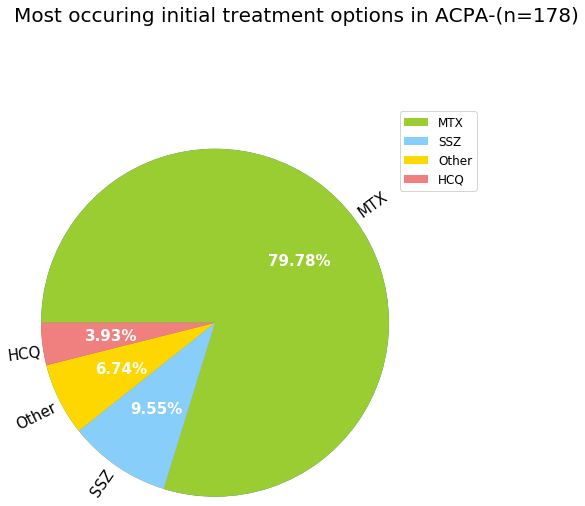

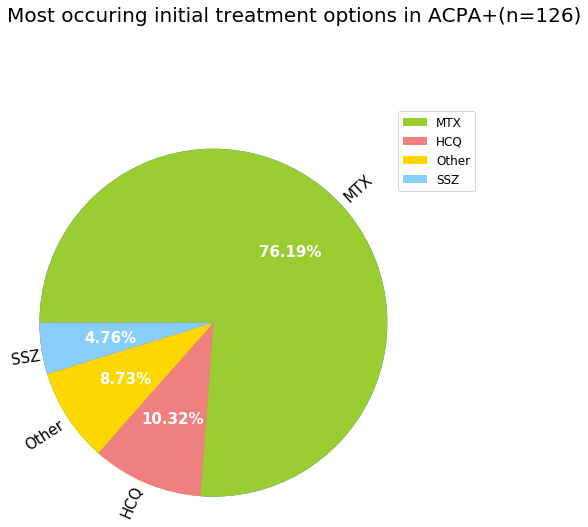

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def makeStackedBar(state, subset, feat, present, desc):
    lbls = ['Men', 'Women']
    drug_list = ['methotrexaat', 'sulfasalazine', 'hydroxychloroquine']
    d_convert = {'hydroxychloroquine': 'HCQ', 'methotrexaat' : 'MTX', 'sulfasalazine' : 'SSZ'}
    colors = ['indianred', 'yellowgreen','yellowgreen', 'gold', 'lightskyblue',  'red', 'blue', 'yellow', 'green']
    table=pd.crosstab(df_Init[((df_Init[subset]==present))][feat],df_Init[((df_Init[subset]==present))][state])
    print(table)
    ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', width=0.9, stacked=True,figsize=(5,6), color=colors, fontsize= 12)

    totals = {}

    labels = [item.get_text() for item in ax.get_xticklabels()]
    count = 0
    for x in labels:
        #print(x, len(df_Init[(df_Init[feat]==x)]))
        labels[count] = str(x) + ' \n(n = ' + \
            str(len(df_Init[((df_Init[subset]==present) & (df_Init[feat]==int(float(x))))])) + ')' 
        count += 1
    grp1 = df_Init[((df_Init[subset]==present) & (df_Init[feat] == 0))]['status'].value_counts().sort_index().values
    grp2 = df_Init[((df_Init[subset]==present) & (df_Init[feat] == 1))]['status'].value_counts().sort_index().values

    
    obs= [list(grp1), list(grp2)]
    print(obs)
    oddsratio, p = stats.fisher_exact(obs)
    print('Diff in ' + d_convert[present] + ' response by ' + feat + ' :' , p)

    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/10, i.get_y()+i.get_height()/2, \
                str(round(i.get_height()*100, 2))+'%', fontsize=16,
                    color='white')
    ax.set_xticklabels(labels, rotation=0)
    ax.legend(bbox_to_anchor=(1.10, -0.2, 0.2, 1.7), fontsize=12)
    L=ax.legend(bbox_to_anchor=(1.10, -1.4, 0.4, 1.7), fontsize=12)
    L.get_texts()[0].set_text('No remission')
    L.get_texts()[1].set_text('Remission')
    #ax.get_legend().remove()
    ax.set_title('Remission rate of initial treatment ' + desc, fontsize= 16)
    ax.set_xlabel('\n'+ desc, fontsize= 16)
    ax.set_ylim(0, 1.5)
    ax.set_ylabel('Prop. remission', fontsize= 12)
    return ax

def makeCirclePlot(state, subset, present, desc):
    colors = []
    group_size=list(df_Init[(df_Init[subset]==present)]['drug1'].value_counts().values)
    labels=list(df_Init[(df_Init[subset]==present)]['drug1'].value_counts().keys())
    d_short = {'methotrexaat': 'MTX', 'hydroxychloroquine': 'HCQ', 'sulfasalazine': 'SSZ', 'Other' : 'Other'}
    print('sum', sum(group_size))
    print(labels)
    print(df_Init[(df_Init[subset]==present)]['drug1'].value_counts())
    
    for drug in labels:
        colors.append(d_color[drug])
    labels= list(map(d_short.get, labels))
    
    
    #colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    fig, ax = plt.subplots()
    ax.axis('equal')

    pie1 = ax.pie(group_size, radius=2,  rotatelabels = 90, startangle=180,counterclock=False, autopct='%1.2f%%', textprops={'fontsize': 15 , 'color': 'white', 'weight':'bold'})
    pie2 = ax.pie(group_size, radius=2,  colors=colors, labeldistance=1, labels=labels, rotatelabels = 90,
    startangle=180,counterclock=False, textprops={'fontsize': 15})

    #plt.title('Occurences of treatment')
    plt.suptitle('Most occuring initial treatment options in ' + desc + '(n='+ str(len(df_Init[(df_Init[subset]==present)])) + ')', size=20, y=1.60, x=.70)
    plt.legend(bbox_to_anchor=(1.10, -0.2, 0.2, 1.7), fontsize=12)
    return plt

def makeStackedBarPlot(state, subset, present, desc):
    colors = []
    group_size=list(df_Init[(df_Init[subset]==present)]['drug1'].value_counts().values)
    labels=list(df_Init[(df_Init[subset]==present)]['drug1'].value_counts().keys())
    d_short = {'methotrexaat': 'MTX', 'hydroxychloroquine': 'HCQ', 'sulfasalazine': 'SSZ', 'Other' : 'Other'}
    print('sum', sum(group_size))
    print(labels)
    print(df_Init[(df_Init[subset]==present)]['drug1'].value_counts())
    
    for drug in labels:
        colors.append(d_color[drug])
    labels= list(map(d_short.get, labels))
    
    
    #colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    fig, ax = plt.subplots()
    ax.axis('equal')

    pie1 = ax.pie(group_size, radius=2,  rotatelabels = 90, startangle=180,counterclock=False, autopct='%1.2f%%', textprops={'fontsize': 15 , 'color': 'white', 'weight':'bold'})
    pie2 = ax.pie(group_size, radius=2,  colors=colors, labeldistance=1, labels=labels, rotatelabels = 90,
    startangle=180,counterclock=False, textprops={'fontsize': 15})

    #plt.title('Occurences of treatment')
    plt.suptitle('Most occuring initial treatment options in ' + desc + '(n='+ str(len(df_Init[(df_Init[subset]==present)])) + ')', size=20, y=1.60, x=.70)
    plt.legend(bbox_to_anchor=(1.10, -0.2, 0.2, 1.7), fontsize=12)
    return plt


#plt.subplots(2, 2, sharex='col')
state = 'status'
subset = 'drug1'
feat = 'aCCP'
#grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)


makeStackedBar(state, subset, feat, 'methotrexaat', 'MTX')
makeStackedBar(state, subset, feat, 'hydroxychloroquine', 'HCQ')
makeStackedBar(state, subset, feat, 'sulfasalazine', 'SSZ')
subset = 'aCCP'

#makeStackedBar(state, subset, feat, 0, 'Men')

makeCirclePlot(state, subset, 1, 'ACPA-')

print(len(df_Init[(df_Init[subset]==1)]))
print(len(df_Init[(df_Init[subset]==0)]))

makeCirclePlot(state, subset, 0, 'ACPA+')

#plt.subplot(2, 1, 2)
#makeStackedBar(state, subset, 1, 'Women')



#obs = np.array(table)
test = 'c'
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)
#print(p)
#print(oddsratio)
#plt.Annotation('lala')

#plt.savefig('figures/ ' + feat + 'ProportionsInitialTreatment.png')

### Initial Therapy SSZ - Women vs Men
Women receive sulfasalazine more often than men

In [77]:
obs = np.array([[7, 183], [13, 115]])
test = 'f'
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)
print(p)

0.031640658022353794


### Initial therapy SSZ - ACPA+ vs ACPA-

In [74]:
obs = np.array([[178, 12], [126, 2]])
test = 'f'
if test == 'f':
    oddsratio, p = stats.fisher_exact(obs)
else :
    chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)
print(p)

0.05143388666537865


### Create Violin Plots -> DAS at first visit

No handles with labels found to put in legend.


43
64


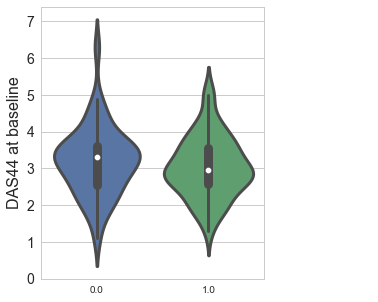

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
#ax = sns.violinplot(x=tips["total_bill"])

feat = 'aCCP'
continuous = 'BeginDAS44'
present= 0
plt.figure(figsize=(4,5))
df_set = df_Init[((df_Init['drug1'].isin(['methotrexaat'])))].copy()
#df_set['drug1'] = df_set['drug1'].cat.remove_unused_categories()
df_set =df_set[~df_set[continuous].isna()]
ax = sns.violinplot(x=feat, y=continuous, data=df_set, inner='box', height=2, aspect=.7, bw=.4, linewidth=3).set(ylim=(0))
#plt.Axes.set_xticklabels(self, labels=['a','b','c', 'd', 'e', 'f', 'g'])

plt.title('')
plt.yticks(fontsize=14)
plt.ylabel('DAS44 at baseline', fontsize=16)
#plt.xticks(fontsize=14)
plt.xlabel('')
L=plt.legend(bbox_to_anchor=(1.10, -1.4, 0.4, 1.7))
for i in range(len(L.get_texts())):
    L.get_texts()[i].set_text(subset + ' == ' + str(i))
plt.rcParams.update({'font.size': 39})
#plt.show()
print(len(df_set[df_set[feat]==0]))
print(len(df_set[df_set[feat]==1]))